In [39]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics 
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler


In [40]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/regression_sprint/enviro_indicators.csv', index_col=0)
dataset.head()

,forest_coverage,biodiversity_index,protected_areas,deforestation_rate,carbon_sequestration,soil_erosion,land_degradation,rural_population,population_density
Country,,,,,,,,,
Vietnam,36.217808,6.505159,14.832708,36.583106,53.128459,7.987880,55.020903,35.912142,468.715839
Guinea-Bissau,76.550001,94.888554,23.994363,123.384939,279.836286,13.013811,41.655073,34.639379,351.054600
Bosnia and Herzegovina,61.239576,96.563203,9.932348,115.743745,237.834951,13.037065,26.951490,78.380633,289.329973
Lesotho,51.906094,80.839735,33.076894,111.752369,149.948515,11.179719,27.460479,43.585863,57.616482
Indonesia,20.921305,30.461377,7.609273,46.450326,103.939415,2.715506,46.297784,73.522793,311.353541


In [41]:
# Split the dataset 
X = dataset.drop(columns=["biodiversity_index"])
y = dataset["biodiversity_index"]

In [42]:
# Split the data into training and testing tests
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Scale the training set 
scaler = StandardScaler() 

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

# Build back the dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=[column for column in X_train.columns.to_list()], index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=[column for column in X_test.columns.to_list()], index=X_test.index)

In [44]:
# Fit a stacking regressor 
base_learners = [
    ("ridge", RidgeCV()),
    ("dt", DecisionTreeRegressor(max_depth=4, random_state=42)),
    ("rf", RandomForestRegressor(max_depth=4, random_state=42, n_estimators=50))
]

meta_learner = GradientBoostingRegressor(
    n_estimators=10,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

cross_validation = KFold(n_splits=5, shuffle=True, random_state=42)

In [45]:
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=cross_validation,
    n_jobs=-1
)

stacking_model.fit(X_train_scaled, y_train)

,estimators,"[('ridge', ...), ('dt', ...), ...]"
,final_estimator,GradientBoost...ndom_state=42)
,cv,KFold(n_split... shuffle=True)
,n_jobs,-1
,passthrough,False
,verbose,0
,alphas,"(0.1, ...)"
,fit_intercept,True
,scoring,None
,cv,None
,gcv_mode,None


In [46]:
# Make predictions 
y_predicted = stacking_model.predict(X_test_scaled) 

# Evaluate 
print(f"MSE: {metrics.mean_squared_error(y_test, y_predicted)}\nR2 Score: {metrics.r2_score(y_test, y_predicted)}")

MSE: 356.0611641177928
R2 Score: 0.4236816403778687


<Axes: ylabel='biodiversity_index'>

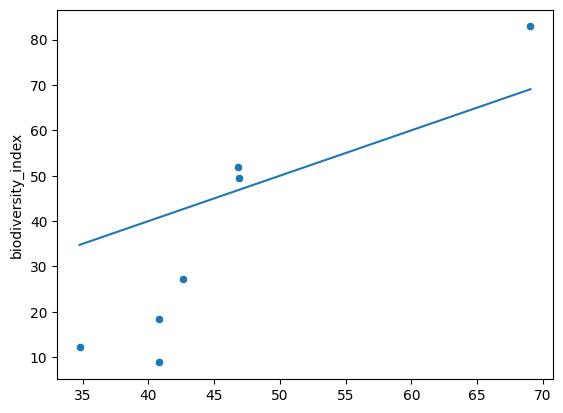

In [47]:
sns.lineplot(x=y_predicted, y=y_predicted)
sns.scatterplot(y=y_test, x=y_predicted)

In [48]:
# Using the RandomForestRegressor()

random_forest_model = RandomForestRegressor(n_estimators=150, random_state=42, max_depth=6).fit(X_train_scaled, y_train) 
y_predicted = random_forest_model.predict(X_test_scaled)
print(f"MSE: {metrics.mean_squared_error(y_test, y_predicted)}\nR2 Score: {metrics.r2_score(y_test, y_predicted)}")

MSE: 164.06828273640733
R2 Score: 0.7344401100104665


<Axes: ylabel='biodiversity_index'>

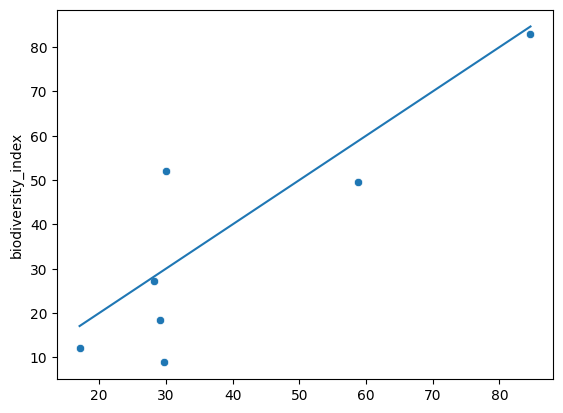

In [49]:
sns.lineplot(x=y_predicted, y=y_predicted)
sns.scatterplot(y=y_test, x=y_predicted)

In [50]:
# Single Decision Trees 
decision_tree_model = DecisionTreeRegressor(max_depth=4, random_state=42).fit(X_train_scaled, y_train) 
y_predicted = decision_tree_model.predict(X_test_scaled)
print(f"MSE: {metrics.mean_squared_error(y_test, y_predicted)}\nR2 Score: {metrics.r2_score(y_test, y_predicted)}")

MSE: 164.58378923469962
R2 Score: 0.7336057144363058


In [51]:
feature_importance = pd.DataFrame(random_forest_model.feature_importances_, index=[column for column in X_train_scaled.columns.to_list()], columns=["Importance"])
feature_importance.sort_values(by="Importance", ascending=False)

,Importance
deforestation_rate,0.918007
forest_coverage,0.021791
population_density,0.012944
rural_population,0.012514
protected_areas,0.012334
soil_erosion,0.010544
land_degradation,0.008212
carbon_sequestration,0.003653


<Axes: ylabel='biodiversity_index'>

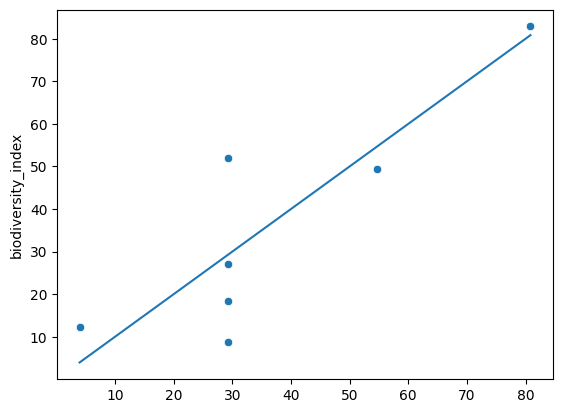

In [52]:
sns.lineplot(x=y_predicted, y=y_predicted)
sns.scatterplot(y=y_test, x=y_predicted)

In [53]:
# Using Linear Regression
linear_regression_model = LinearRegression().fit(X_train_scaled, y_train)
y_predicted = linear_regression_model.predict(X_test_scaled)
print(f"MSE: {metrics.mean_squared_error(y_test, y_predicted)}\nR2 Score: {metrics.r2_score(y_test, y_predicted)}")

MSE: 20.602909520487962
R2 Score: 0.9666522602999672
